In [4]:
# Instalar as bibliotecas necessárias
!pip install tensorflow -q

In [34]:
# Bibliotecas padrão
import os

# Bibliotecas para manipulação de dados
import numpy as np

# Bibliotecas para visualização
import matplotlib.pyplot as plt

# Bibliotecas de deep learning
import tensorflow as tf
from tensorflow import keras

# Bibliotecas de manipulação de imagens
import cv2

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


## Carregando libs e inicialização de variáveis

Vamos carregar as libs necessárias para manipulação dos dados e visualizações.


In [35]:
# Define caminho da pasta do projeto
DATASET_PATH = 'farmtech_yolo_project/dataset'

# Caminho para os conjuntos de dados
train_path = os.path.join(DATASET_PATH, 'train/images')
test_path = os.path.join(DATASET_PATH, 'test/images')
valid_path = os.path.join(DATASET_PATH, 'valid/images')

print(f"✅ Dataset path: {DATASET_PATH}")


✅ Dataset path: farmtech_yolo_project/dataset


## Carregando o dataset

Vamos criar uma função para carregar as imagens e seus respectivos labels baseado no nome do arquivo.


In [36]:
def load_images_and_labels(images_path, img_size=(128, 128)):
    """Carrega imagens e cria labels: cat=0, dog=1"""
    images = []
    labels = []
    
    files = sorted(os.listdir(images_path))
    
    for filename in files:
        if filename.endswith('.jpg'):
            img_path = os.path.join(images_path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            
            if len(img.shape) == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            
            images.append(img)
            
            if filename.startswith('cat'):
                labels.append(0)
            elif filename.startswith('dog'):
                labels.append(1)
    
    return np.array(images), np.array(labels)

In [37]:
train_images, train_labels = load_images_and_labels(train_path)
test_images, test_labels = load_images_and_labels(test_path)
valid_images, valid_labels = load_images_and_labels(valid_path)

print(f"Train: {train_images.shape}")
print(f"Test: {test_images.shape}")
print(f"Valid: {valid_images.shape}")


Train: (64, 128, 128, 3)
Test: (8, 128, 128, 3)
Valid: (8, 128, 128, 3)


In [38]:
# Definir as classes
CLASS_NAMES = ['Cat', 'Dog']


## Visualizando as imagens do dataset

Para entender se o nosso dataset está sendo carregado corretamente, vamos imprimir amostra aleatórias das imagens contidas no dataset.


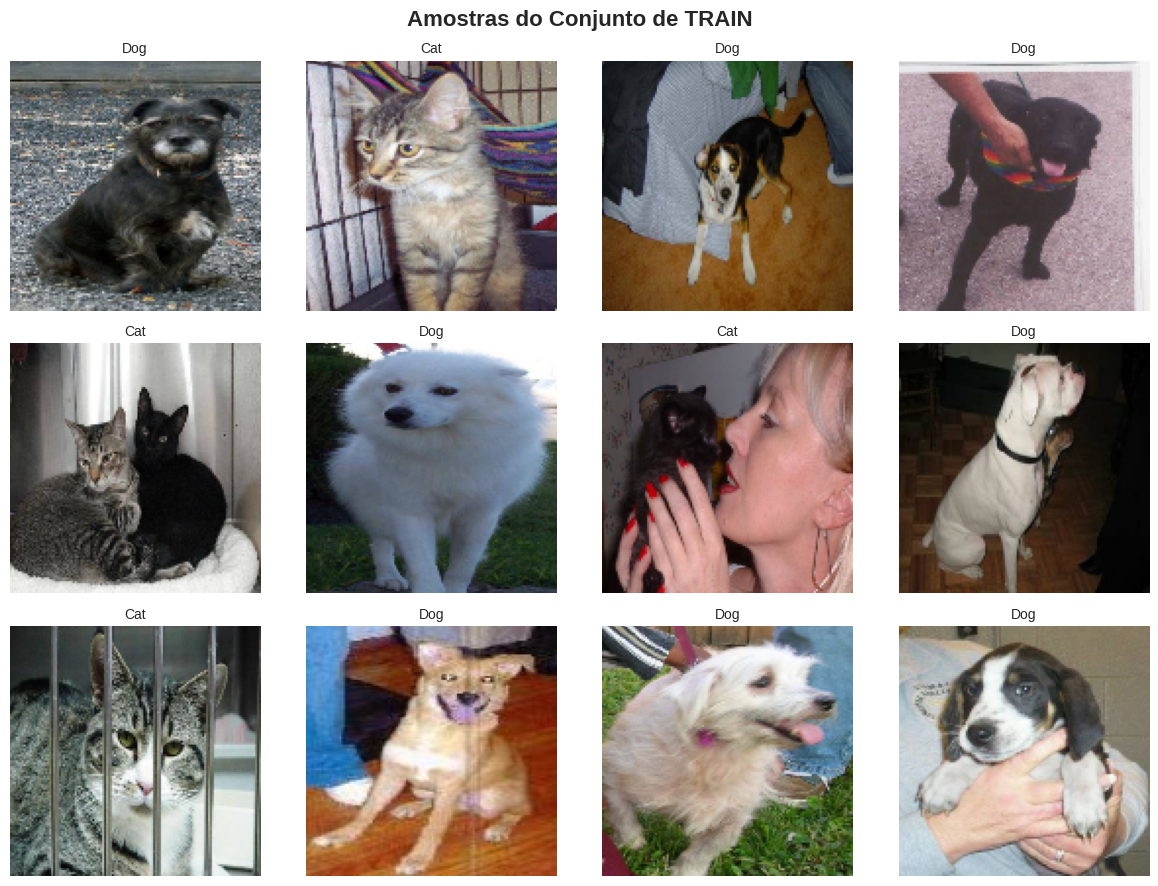

In [40]:
import random

# Visualizar amostras aleatórias do dataset de treino
num_samples = 12
random_indices = random.sample(range(len(train_images)), num_samples)

cols = 4
rows = 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 9))
axes = axes.flatten()

for idx, img_idx in enumerate(random_indices):
    axes[idx].imshow(train_images[img_idx])
    axes[idx].set_title(f'{CLASS_NAMES[train_labels[img_idx]]}', fontsize=10)
    axes[idx].axis('off')

plt.suptitle('Amostras do Conjunto de TRAIN', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [41]:
# Normalizar os dados (0-255 -> 0-1)
train_images = train_images / 255.0
test_images = test_images / 255.0
valid_images = valid_images / 255.0

print(f"✅ Imagens normalizadas: [{train_images.min():.2f}, {train_images.max():.2f}]")


✅ Imagens normalizadas: [0.00, 1.00]


## Criando o modelo CNN

Vamos criar um modelo de rede neural convolucional (CNN) utilizando TensorFlow/Keras para classificação binária.


In [42]:
tf.random.set_seed(42)

model = keras.Sequential([
    keras.layers.Input(shape=(128, 128, 3)),
    
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Modelo CNN criado e compilado")


✅ Modelo CNN criado e compilado


In [44]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## Treinando o Modelo

Vamos treinar o modelo com **20 épocas** usando batch size de 8.


In [45]:
history = model.fit(
    train_images, 
    train_labels, 
    epochs=20,
    validation_data=(valid_images, valid_labels),
    batch_size=8
)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.4062 - loss: 0.8756 - val_accuracy: 0.5000 - val_loss: 0.6784
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5156 - loss: 0.6884 - val_accuracy: 0.6250 - val_loss: 0.6865
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5000 - loss: 0.6945 - val_accuracy: 0.7500 - val_loss: 0.6794
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5156 - loss: 0.7035 - val_accuracy: 0.7500 - val_loss: 0.6506
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6250 - loss: 0.6538 - val_accuracy: 0.7500 - val_loss: 0.6408
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7344 - loss: 0.5955 - val_accuracy: 0.6250 - val_loss: 0.6686
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7500 - loss: 0.5373 - val_accuracy: 0.6250 - val_loss: 0.6709
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8438 - loss: 0.4220 - val_accuracy: 0.5000 - val_loss: 0.8061


## Avaliação do Modelo

Avaliar o modelo com o conjunto de teste.


In [46]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print(f"\n📊 Test Loss: {test_loss:.4f}")
print(f"📊 Test Accuracy: {test_acc:.4f}")


1/1 - 0s - 141ms/step - accuracy: 0.5000 - loss: 0.8042

📊 Test Loss: 0.8042
📊 Test Accuracy: 0.5000


## Visualizando métricas de treinamento

Gráficos de acurácia e perda durante o treinamento.


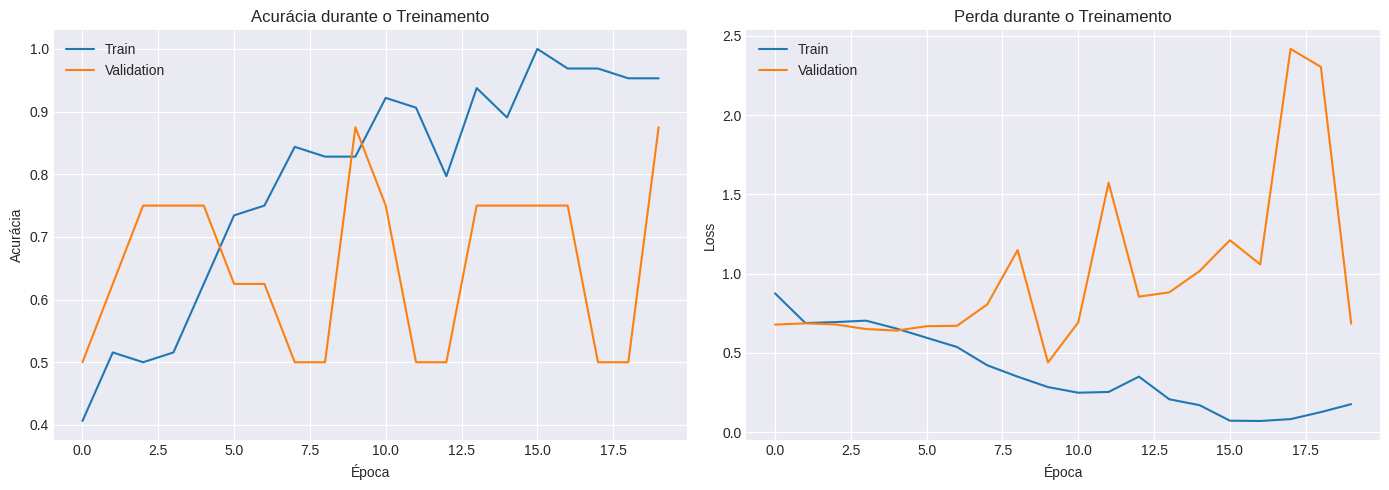

In [47]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Acurácia durante o Treinamento')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.title('Perda durante o Treinamento')
plt.grid(True)

plt.tight_layout()
plt.show()


## Predições

Visualizar predições do modelo nas imagens de teste.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


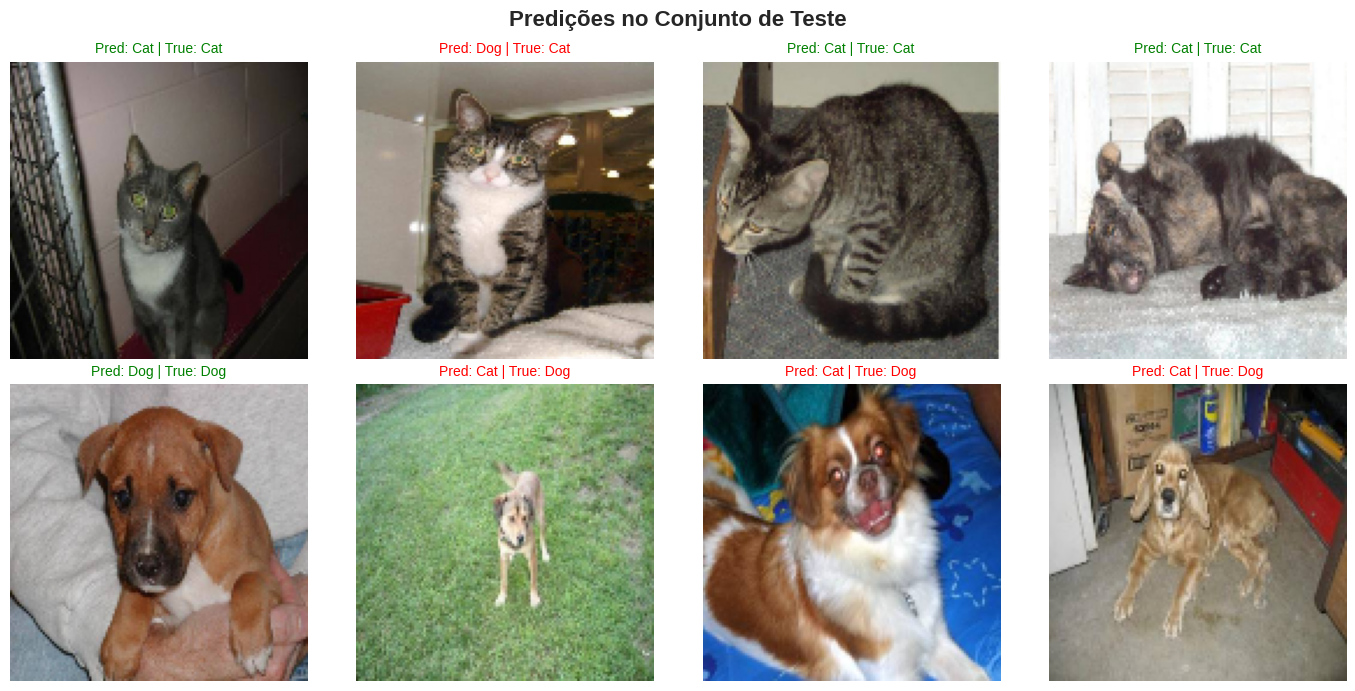

In [48]:
predictions = model.predict(test_images)

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for i in range(len(test_images)):
    predicted_label = np.argmax(predictions[i])
    true_label = test_labels[i]
    
    axes[i].imshow(test_images[i])
    color = 'green' if predicted_label == true_label else 'red'
    axes[i].set_title(f"Pred: {CLASS_NAMES[predicted_label]} | True: {CLASS_NAMES[true_label]}", 
                      color=color, fontsize=10)
    axes[i].axis('off')

plt.suptitle('Predições no Conjunto de Teste', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## Resumo

Este notebook demonstrou a aplicação de CNNs para classificação de imagens usando TensorFlow/Keras.

**Arquitetura**: CNN com 3 camadas convolucionais (32, 64, 128 filtros) + MaxPooling + Dense (128) + Dropout (0.5) + Saída (2 classes)

**Dataset**: 64 treino / 8 validação / 8 teste

**Treinamento**: 20 épocas, batch size 8, optimizer Adam
